> # Neural Network Basic - Week3 과제


## Import Library

In [111]:
import numpy as np
from matplotlib import pyplot as plt
from mnist import load_mnist

## Load Dataset
- MNIST 

In [112]:
(X_train, Y_train), (X_test, Y_test) = \
    load_mnist(normalize=True, one_hot_label=False)

In [113]:
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'Y_train shape: {Y_train.shape}')
print(f'Y_train shape: {Y_test.shape}')

X_train shape: (60000, 784)
X_test shape: (10000, 784)
Y_train shape: (60000,)
Y_train shape: (10000,)


## Activation Function 

뉴런 활성화
- sigmoid & relu : hidden layer activation function 
- softmax : output layer activation function 

In [114]:
class sigmoid:
    # sigmoid 함수를 작성하세요 
    def forward(x):
        return 1/(1+np.exp(-x))
    
    # sigmoid 함수의 미분을 작성하세요
    def backward(x):
        return x*(1-x)

In [115]:
class relu:
    # relu 함수를 작성하세요
    def forward(x):
      return np.maximum(0,x) #0과 x중 더 큰 함수를 return,즉 0보다 작다면 0,0보다 크거나 같다면 x그대로 return된다.
    
    # relu 함수의 미분을 작성하세요
    def backward(x):
        return np.where(x > 0, 1, 0) # 0 보다 큰 값은 1의 gradient 값을 갖게끔 세팅

In [116]:
class softmax:
    def forward(z):
        y = []
        for zi in z:
            c = np.max(zi)
            exp_zi = np.exp(zi-c)
            sum_exp_zi = np.sum(exp_zi)
            yi = exp_zi / sum_exp_zi
            y.append(yi)

        return np.array(y)
    
    def backward(p, y) :
        dp = p.copy()
        for dpi, yi in zip(dp, y):
            for k in range(dp.shape[1]):
                if k == yi :
                    dpi[k] -= 1
        return dp

## Loss Function

:알고리즘이 얼마나 데이터셋을 잘 나타내는가(예측과 실제값 사이의 차이)를 평가해주는 지표
loss function이 높을수록 예측이 좋지 않음.

In [117]:
def cross_entropy(p, y):
    loss = []
    for pi, yi in zip(p, y):
        for k in range(p.shape[1]):
            if k == yi:
                loss.append((-1) * (np.log(pi[k] + 1e-8))) 
    return loss

## Layer

In [118]:
class Layer:
    def __init__(self, input_size, output_size, std=1e-4) :
        self.input_size = input_size
        self.output_size = output_size
        self.bias = np.random.randn(output_size)
        self.weight = np.random.randn(input_size, output_size)*std

## Neural Network
- 각 메소드와 변수들의 역할을 주석으로 달아주세요! 

In [119]:
class CustomNet:
    # CustomNet을 선언할 때 생성되는 값들입니다.
    def __init__(self, lr=0.0001, epoch=500, batch_size=200):
      #한번에 어느정도씩 움직여 최종적인 global minimum을 찾을 것인지 정함.
        self.lr = lr
        #모델이 학습을 몇번이나 반복할 것인지 정함.
        self.epoch = epoch  
        #모델이 몇개의 데이터로 총 데이터를 나누어 학습할 것인지 기준을 정함
        self.batch_size = batch_size
        #모델이 잘 만들어졌는지 평가하는 지표(높을수록 성능이 떨어지는 모델)
        self.loss_function = cross_entropy 
        #layer를 담고있는 배열
        self.layers = []
        #output을 내보낼 때의 활성화 함수 softmax를 담고 있는 배열
        self.activations = [softmax]
        #레이어의 노드 수(모델이 복잡하면 복잡해질수록 은닉층의 수와 노드의 수는 늘어난다.)
        self.nodes = []
    
    # Layer를 추가할 때 호출합니다
    def addLayer(self, Layer): 
        self.layers.append(Layer) #층을 추가하기 위해 append사용
        if not self.nodes: 
            self.nodes.append(np.zeros(Layer.input_size))#맨 처음,노드가 비어있을 시,input_size에 대한 정보 추가 
        self.nodes.append(np.zeros(Layer.output_size))#output 노드들의 수를 추가해가며 Layer의 노드 수를 담는다
        #np.zeros(0으로만 채워진 array 생성)
    # Activation Function을 추가할 때 호출합니다
    #activation을 쓰지 않으면 결국 하나의 layer를 쌓은 것과 다르지 않기 때문에 중요한 역할(gradient vanishing을 극복하도록 발전하고 있다.)
    #
    def addActivation(self, Activation):
        tmp = self.activations.pop() #pop함수는 리스트의 맨마지막 요소를 돌려주고 해당 리스트에선 삭제시키는 함수로 가장 뒷단의 활성 함수를 추출한다.
        self.activations.append(Activation) #활성함수 추가
        self.activations.append(tmp) #추출한 함수를 마지막단에 붙여줌.
        
    # 순전파 함수
    def _forward(self, X):
        self.nodes[0] = X.copy() #X의 배열 복사하여 첫번째 노드 초기화
        output = X.copy() 
        for i in range(len(self.layers)): #레이어의 층 수만큼 반복문 돌림.
            Layer = self.layers[i] 
            Activation = self.activations[i] #층 별 활성화 함수 실행
            output = np.dot(self.nodes[i], Layer.weight) #numpy의 dot함수:각 원소를 곱한 값들을 더한 내적 연산 수행,이 경우엔 노드에 가중치 곱해 더하기
            output = output+ Layer.bias #최종output 낼 때,위의 값에 bias더해주기
            output = Activation.forward(output) 
            self.nodes[i+1] = output #다음 노드값으로 초기화
        return output   
    
    # 역전파 함수
    def _backward(self, X, output, y) :
        for i in reversed(range(len(self.layers))): #레이어의 수의 반대순서로 반복문 실행
            a = self.nodes[i+1] #다음 레이어의 값 저장
            Layer = self.layers[i] #레이어는 현재 레이어 값 저장
            Activation = self.activations[i] #현재 레이어 활성화 함수 저장
            
            if i+1 == len(self.layers):
                error = Activation.backward(output, y)
            else:
                error *= Activation.backward(a)
            Layer.weight -= np.dot(error.T, self.nodes[i]).T*self.lr/X.shape[0] #error.T와 learning rate를 이용해 가중치 업데이트
            Layer.bias -= error.sum(axis=0)*self.lr/X.shape[0]#상수값 업데이트
            error = np.dot(error, Layer.weight.T)#에러값 계산
            
    # Accrucy를 반환합니다
    def _accuracy(self, output, y):
        pre_p = np.argmax(output, axis=1)#np.argmax 가장 큰 원소의 인덱스 반환:softmax함수를 통해 나온 여러 확률값 중 가장 높은 확률 가지는 인덱스 값 반환
        return np.sum(pre_p==y)/y.shape[0]  #분류가 잘 된 개수의 비율
    
    # 데이터셋에 모델을 fit할때 호출합니다
    def fit(self, X, y, val_X, val_y):
        history = {'val_acc': [],'val_loss': []} 
        N = X.shape[0]
        for i in range(self.epoch):#epoch수만큼 학습 진행
            for j in range(N//self.batch_size): ##mini batch의 크기만큼 진행
                batch_mask = np.random.choice(N, self.batch_size) #batch size 만크믜 N개의 mask선택
                X_batch = X[batch_mask] #batch추출
                y_batch = y[batch_mask] #Y_batch추출
                output = self._forward(X_batch) #output에는 위의 forward에 X_batch넣는 값 저장(순전파)
                self._backward(X_batch, output, y_batch)#위의 backward함수(역전파) 사용하여 인수로 X_batch,output,y_batch 넣어줌.
            
            #accuracy와 loss를 기록해둡시다
            output = self._forward(val_X) #val_x에 순전파 적용
            history["val_acc"].append(self._accuracy(output, val_y)) #val data의 정확도
            history["val_loss"].append(sum(self.loss_function(output, val_y))) #val data의 loss
            
            #중간중간 기록을 찍어볼 때 사용. 적절히 조절해 쓰세요
            if i % 10 == 0:
                print(i, "test accuracy :", history["val_acc"][-1]) #진행되고 있는 상황에서 가장 최근 accracy추출
                print(i, "test loss     :", history["val_loss"][-1]) #진행되고 있는 상황에서 가장 최근 loss추출
        return history

## Customizing
- Network parameter, Layer architecture, Activation function .. 등등 다양한 하이퍼파라미터를 커스터마이징하여 높은 성능에 도달해 봅시다! 

In [120]:
# 하이퍼파라미터를 적절히 조절해 뉴럴넷을 선언하세요
nn = CustomNet(lr=0.01, epoch=130, batch_size=400)

# 원하는 만큼 층과 활성화 함수를 쌓아 주세요. 기본적으로 2Layer를 예시로 적어드립니다
nn.addLayer(Layer(784,100))
nn.addActivation(sigmoid)
nn.addLayer(Layer(100,10))

In [121]:
# 선언한 뉴럴넷의 구조입니다
for layer in nn.layers:
    print(layer.weight.shape, layer.bias.shape)

(784, 100) (100,)
(100, 10) (10,)


In [122]:
history = nn.fit(X_train, Y_train, X_test, Y_test)
##accracy가 꽤나 잘나옴.

0 test accuracy : 0.1135
0 test loss     : 23016.21054745549
10 test accuracy : 0.1242
10 test loss     : 22895.66302173228
20 test accuracy : 0.2562
20 test loss     : 22168.079231162155
30 test accuracy : 0.3616
30 test loss     : 19037.330269728252
40 test accuracy : 0.5031
40 test loss     : 15193.643989106882
50 test accuracy : 0.6351
50 test loss     : 11830.740898497294
60 test accuracy : 0.7287
60 test loss     : 9359.163714567496
70 test accuracy : 0.7865
70 test loss     : 7656.246997302477
80 test accuracy : 0.8285
80 test loss     : 6428.8037219108355
90 test accuracy : 0.8516
90 test loss     : 5575.471887691507
100 test accuracy : 0.8649
100 test loss     : 4985.682347389658
110 test accuracy : 0.8766
110 test loss     : 4563.4025692895575
120 test accuracy : 0.8853
120 test loss     : 4252.278664491544


## Accuracy, Loss Visualization
- 자유롭게 Accuracy나 Loss를 시각화하여 확인하고 결과를 확인해 보세요! 

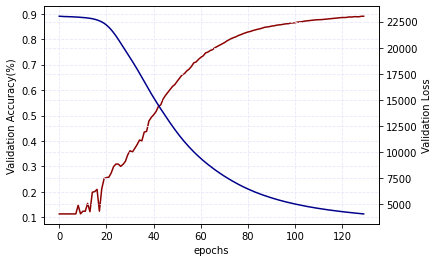

Best Validation Accuracy :  0.8902


In [126]:
#loss와 accuracy를 함께 시각화해주는 코드
fig = plt.figure()
ax_acc = fig.add_subplot(111)
#range(x)_x는 epoch숫자
ax_acc.plot(range(130), history['val_acc'], label='정확도(%)', color='darkred')
plt.xlabel('epochs')
plt.ylabel('Validation Accuracy(%)')
ax_acc.grid(linestyle='--', color='lavender')
ax_loss = ax_acc.twinx()
ax_loss.plot(range(130), history['val_loss'], label='오차', color='darkblue')
plt.ylabel('Validation Loss')
ax_loss.yaxis.tick_right()
ax_loss.grid(linestyle='--', color='lavender')

# 그래프 표시
plt.show()

# 최고 validation accuracy는?
print("Best Validation Accuracy : ",max(history['val_acc']))

In [128]:
#학습률이 0.01로 해봤을 때 결과가 잘 나왔기에 같은 조건으로 0.1~0.5사이로 학습률을 바꿔봄.
#0.8902->0.9548성능 향상
nn = CustomNet(lr=0.03, epoch=100, batch_size=400)

nn.addLayer(Layer(784,100))
nn.addActivation(relu)
nn.addLayer(Layer(100,10))

history = nn.fit(X_train, Y_train, X_test, Y_test)


0 test accuracy : 0.2611
0 test loss     : 21625.198793181233
10 test accuracy : 0.8887
10 test loss     : 4132.971116569673
20 test accuracy : 0.9119
20 test loss     : 3098.031546027357
30 test accuracy : 0.9231
30 test loss     : 2676.0298241149935
40 test accuracy : 0.9288
40 test loss     : 2415.9512118882453
50 test accuracy : 0.9361
50 test loss     : 2191.718923422032
60 test accuracy : 0.9419
60 test loss     : 2007.9699501961668
70 test accuracy : 0.9463
70 test loss     : 1855.5836172435568
80 test accuracy : 0.9498
80 test loss     : 1726.1108434676423
90 test accuracy : 0.9528
90 test loss     : 1616.1526422187703


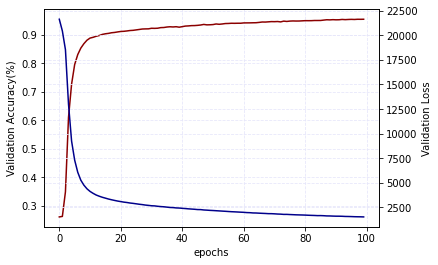

Best Validation Accuracy :  0.9548


In [129]:
fig = plt.figure()
ax_acc = fig.add_subplot(111)

ax_acc.plot(range(100), history['val_acc'], label='정확도(%)', color='darkred')
plt.xlabel('epochs')
plt.ylabel('Validation Accuracy(%)')
ax_acc.grid(linestyle='--', color='lavender')
ax_loss = ax_acc.twinx()
ax_loss.plot(range(100), history['val_loss'], label='오차', color='darkblue')
plt.ylabel('Validation Loss')
ax_loss.yaxis.tick_right()
ax_loss.grid(linestyle='--', color='lavender')

# 그래프 표시
plt.show()

# 최고 validation accuracy는?
print("Best Validation Accuracy : ",max(history['val_acc']))

In [130]:
#활성화 함수 relu사용.
nn = CustomNet(lr=0.01, epoch=100, batch_size=400)

nn.addLayer(Layer(784,100))
nn.addActivation(relu)
nn.addLayer(Layer(100,10))

history = nn.fit(X_train, Y_train, X_test, Y_test)


0 test accuracy : 0.175
0 test loss     : 22789.36392629042
10 test accuracy : 0.5853
10 test loss     : 13111.39926681791
20 test accuracy : 0.8495
20 test loss     : 5570.024422483963
30 test accuracy : 0.8891
30 test loss     : 4018.7967487271585
40 test accuracy : 0.9019
40 test loss     : 3536.2537582707487
50 test accuracy : 0.9074
50 test loss     : 3264.307032223722
60 test accuracy : 0.912
60 test loss     : 3079.7744640300334
70 test accuracy : 0.9161
70 test loss     : 2953.8996386965778
80 test accuracy : 0.9196
80 test loss     : 2839.9851365606773
90 test accuracy : 0.9229
90 test loss     : 2749.7479025377725


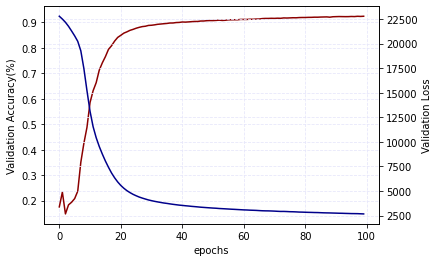

Best Validation Accuracy :  0.9245


In [132]:
#성능이 좋은 편이나, 학습률 0.03에 동일하게 했을 때보단 낮은 성능
fig = plt.figure()
ax_acc = fig.add_subplot(111)

ax_acc.plot(range(100), history['val_acc'], label='정확도(%)', color='darkred')
plt.xlabel('epochs')
plt.ylabel('Validation Accuracy(%)')
ax_acc.grid(linestyle='--', color='lavender')
ax_loss = ax_acc.twinx()
ax_loss.plot(range(100), history['val_loss'], label='오차', color='darkblue')
plt.ylabel('Validation Loss')
ax_loss.yaxis.tick_right()
ax_loss.grid(linestyle='--', color='lavender')

# 그래프 표시
plt.show()

# 최고 validation accuracy는?
print("Best Validation Accuracy : ",max(history['val_acc']))

결론:learning rate를 0.1,0.01,0.001...등 실험해보았을 때 0.01이 제일 잘나와 이를 구체화 시켜
0.03을 시도했더니 0.9548로 가장 좋은 성능이 나왔다.
이때, epoch은 100,나머지 요소들은 동일하게 진행했다.